<a href="https://colab.research.google.com/github/Aaryansohani/Machinelearning_algos/blob/main/Rainfall_Prediction_with_DTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

This tutorial takes a practical and coding-focused approach. We'll learn how to apply _logistic regression_ to a real-world dataset from [Kaggle](https://kaggle.com/datasets):

> **QUESTION**: The [Rain in Australia dataset](https://kaggle.com/jsphyg/weather-dataset-rattle-package) contains about 10 years of daily weather observations from numerous Australian weather stations. Here's a small sample from the dataset:
> 
> ![](https://i.imgur.com/5QNJvir.png)
>
> As a data scientist at the Bureau of Meteorology, you are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow. 
>
>
> ![](https://i.imgur.com/KWfcpcO.png)


In [3]:
import pandas as pd

In [4]:
raw_df = pd.read_csv(r"weatherAUS.csv")

In [5]:
raw_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32892,2015-10-07,Sydney,19.7,21.5,0.0,13.2,1.3,SSW,67.0,SSE,SE,39.0,26.0,61.0,56.0,1029.6,1033.6,5.0,7.0,20.3,19.0,No,No
32893,2015-10-08,Sydney,17.0,21.1,0.0,6.6,2.2,ENE,35.0,ESE,E,13.0,20.0,53.0,57.0,1038.8,1036.0,7.0,7.0,18.5,19.9,No,No
32894,2015-10-09,Sydney,16.8,22.7,0.0,5.4,8.7,ENE,43.0,N,NE,15.0,24.0,51.0,51.0,1034.4,1029.7,7.0,5.0,20.1,22.0,No,No
32895,2015-10-10,Sydney,15.7,24.3,0.0,6.8,9.5,E,24.0,SE,E,2.0,17.0,62.0,60.0,1028.9,1025.8,1.0,4.0,21.2,22.3,No,No


The dataset contains over 145,460 rows and 23 columns. The dataset contains date, numeric and categorical columns. Our objective is to create a model to predict the value in the column `RainTomorrow`.

Let's check the data types and missing values in the various columns.

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32897 entries, 0 to 32896
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           32897 non-null  object 
 1   Location       32897 non-null  object 
 2   MinTemp        32398 non-null  float64
 3   MaxTemp        32527 non-null  float64
 4   Rainfall       32210 non-null  float64
 5   Evaporation    13825 non-null  float64
 6   Sunshine       9380 non-null   float64
 7   WindGustDir    28030 non-null  object 
 8   WindGustSpeed  28034 non-null  float64
 9   WindDir9am     28429 non-null  object 
 10  WindDir3pm     30797 non-null  object 
 11  WindSpeed9am   32068 non-null  float64
 12  WindSpeed3pm   31422 non-null  float64
 13  Humidity9am    32231 non-null  float64
 14  Humidity3pm    31567 non-null  float64
 15  Pressure9am    26213 non-null  float64
 16  Pressure3pm    26217 non-null  float64
 17  Cloud9am       17086 non-null  float64
 18  Cloud3

While we should be able to fill in missing values for most columns, it might be a good idea to discard the rows where the value of `RainTomorrow` or `RainToday` is missing to make our analysis and modeling simpler (since one of them is the target variable, and the other is likely to be very closely related to the target variable). 

In [7]:
raw_df.dropna(subset=['RainTomorrow','RainToday'], inplace=True)

## Exploratory Data Analysis and Visualization

Before training a machine learning model, its always a good idea to explore the distributions of various columns and see how they are related to the target column. Let's explore and visualize the data using the Plotly, Matplotlib and Seaborn libraries.

In [8]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [9]:
px.histogram(raw_df, x='Location', title='Location vs. Rainy Days', color='RainToday')

In [10]:
px.histogram(raw_df, 
             x='Temp3pm', 
             title='Temperature at 3 pm vs. Rain Tomorrow', 
             color='RainTomorrow')

In [11]:
px.histogram(raw_df, 
             x='RainTomorrow', 
             color='RainToday', 
             title='Rain Tomorrow vs. Rain Today')

In [12]:
px.scatter(raw_df.sample(2000), 
           title='Min Temp. vs Max Temp.',
           x='MinTemp', 
           y='MaxTemp', 
           color='RainToday')

## Training, Validation and Test Sets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using an optimization technique. 


2. **Validation set** - used to evaluate the model during training, tune model hyperparameters (optimization technique, regularization etc.), and pick the best version of the model. Picking a good validation set is essential for training models that generalize well.


3. **Test set** - used to compare different models or approaches and report the model's final accuracy. For many datasets, test sets are provided separately. The test set should reflect the kind of data the model will encounter in the real-world, as closely as feasible.


<img src="https://i.imgur.com/j8eITrK.png" width="480">


As a general rule of thumb you can use around 60% of the data for the training set, 20% for the validation set and 20% for the test set. If a separate test set is already provided, you can use a 75%-25% training-validation split.


When rows in the dataset have no inherent order, it's common practice to pick random subsets of rows for creating test and validation sets. This can be done using the `train_test_split` utility from `scikit-learn`. Learn more about it here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_val_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [15]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (19118, 23)
val_df.shape : (6373, 23)
test_df.shape : (6373, 23)


However, while working with dates, it's often a better idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

For the current dataset, we can use the Date column in the dataset to create another column for year. We'll pick the last two years for the test set, and one year before it for the validation set.

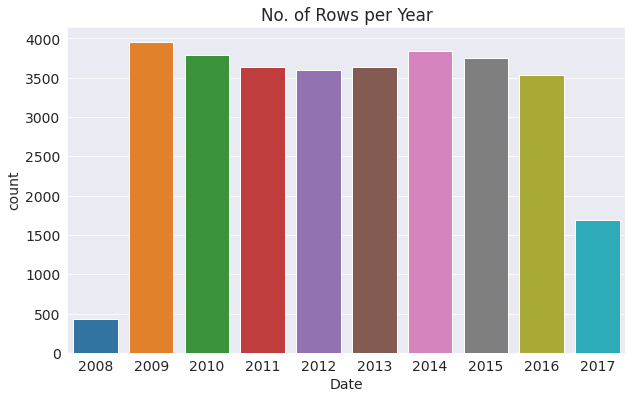

In [16]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year);

In [17]:
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [18]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (22882, 23)
val_df.shape : (3756, 23)
test_df.shape : (5226, 23)


While not a perfect 60-20-20 split, we have ensured that the test validation and test sets both contain data for all 12 months of the year.

In [19]:
train_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32608,2014-12-27,Sydney,18.8,21.7,0.0,10.6,0.0,ENE,31.0,ESE,ESE,11.0,15.0,50.0,53.0,1021.0,1020.6,7.0,7.0,20.6,20.7,No,No
32609,2014-12-28,Sydney,18.9,24.2,0.0,4.0,2.0,ENE,30.0,S,E,2.0,13.0,75.0,61.0,1019.2,1015.9,7.0,7.0,20.2,23.5,No,No
32610,2014-12-29,Sydney,17.7,27.3,0.0,5.4,12.6,NNE,46.0,NNW,NE,13.0,24.0,62.0,66.0,1009.7,1004.1,1.0,1.0,23.6,25.4,No,No
32611,2014-12-30,Sydney,19.4,28.1,0.0,8.0,12.7,SSW,54.0,S,E,13.0,17.0,59.0,50.0,1007.4,1004.0,0.0,0.0,23.4,26.9,No,No


In [20]:
val_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
2133,2015-01-01,Albury,11.4,33.5,0.0,NaN,NaN,WSW,30.0,ESE,W,7.0,11.0,45.0,14.0,1013.5,1011.0,NaN,NaN,21.0,32.7,No,No
2134,2015-01-02,Albury,15.5,39.6,0.0,NaN,NaN,NE,56.0,ESE,ESE,9.0,9.0,45.0,12.0,1016.0,1012.4,NaN,NaN,25.6,38.2,No,No
2135,2015-01-03,Albury,17.1,38.3,0.0,NaN,NaN,NNE,48.0,NE,N,20.0,20.0,35.0,19.0,1017.9,1012.3,NaN,NaN,29.2,37.0,No,No
2136,2015-01-04,Albury,26.0,33.1,0.0,NaN,NaN,NNE,41.0,ESE,W,7.0,7.0,46.0,37.0,1013.6,1012.1,8.0,5.0,27.4,30.9,No,No
2137,2015-01-05,Albury,19.0,35.2,0.0,NaN,NaN,E,33.0,SSE,SE,7.0,9.0,60.0,34.0,1017.4,1014.7,8.0,NaN,25.6,32.5,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32891,2015-10-06,Sydney,20.3,32.3,0.0,8.6,11.4,NNE,43.0,WNW,ENE,15.0,17.0,37.0,26.0,1023.2,1019.7,1.0,1.0,23.8,30.6,No,No
32892,2015-10-07,Sydney,19.7,21.5,0.0,13.2,1.3,SSW,67.0,SSE,SE,39.0,26.0,61.0,56.0,1029.6,1033.6,5.0,7.0,20.3,19.0,No,No
32893,2015-10-08,Sydney,17.0,21.1,0.0,6.6,2.2,ENE,35.0,ESE,E,13.0,20.0,53.0,57.0,1038.8,1036.0,7.0,7.0,18.5,19.9,No,No
32894,2015-10-09,Sydney,16.8,22.7,0.0,5.4,8.7,ENE,43.0,N,NE,15.0,24.0,51.0,51.0,1034.4,1029.7,7.0,5.0,20.1,22.0,No,No


In [21]:
test_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
2498,2016-01-01,Albury,20.4,37.6,0.0,NaN,NaN,ENE,54.0,NaN,ESE,0.0,7.0,46.0,17.0,1013.4,1009.2,7.0,3.0,26.1,36.7,No,No
2499,2016-01-02,Albury,20.9,33.6,0.4,NaN,NaN,SSE,50.0,SSE,SE,9.0,17.0,54.0,30.0,1011.1,1008.4,8.0,8.0,24.8,31.7,No,Yes
2500,2016-01-03,Albury,18.4,23.1,2.2,NaN,NaN,ENE,48.0,ESE,ENE,11.0,39.0,62.0,67.0,1014.0,1014.8,8.0,8.0,21.8,19.5,Yes,Yes
2501,2016-01-04,Albury,17.3,23.7,15.6,NaN,NaN,SSE,39.0,SE,SSE,9.0,17.0,74.0,65.0,1017.9,1016.5,8.0,8.0,19.2,21.6,Yes,Yes
2502,2016-01-05,Albury,15.5,22.9,6.8,NaN,NaN,ENE,31.0,SE,SSE,6.0,9.0,92.0,63.0,1016.3,1013.9,8.0,8.0,17.2,22.2,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30171,2017-06-21,Richmond,5.3,19.1,0.2,NaN,NaN,SW,24.0,NaN,SSE,0.0,15.0,99.0,67.0,1026.5,1025.3,8.0,8.0,6.6,17.8,No,No
30172,2017-06-22,Richmond,4.5,18.1,0.0,NaN,NaN,NE,19.0,NaN,NE,0.0,11.0,91.0,60.0,1029.1,1024.2,NaN,NaN,9.9,17.7,No,No
30173,2017-06-23,Richmond,4.3,17.7,0.0,NaN,NaN,WNW,20.0,S,NNE,6.0,4.0,99.0,71.0,1021.0,1014.9,5.0,NaN,7.0,16.5,No,No
30174,2017-06-24,Richmond,2.5,19.8,0.0,NaN,NaN,W,26.0,W,SSW,4.0,7.0,85.0,39.0,1017.8,1015.2,NaN,NaN,9.6,19.3,No,No


## Identifying Input and Target Columns

Often, not all the columns in a dataset are useful for training a model. In the current dataset, we can ignore the `Date` column, since we only want to weather conditions to make a prediction about whether it will rain the next day.

Let's create a list of input columns, and also identify the target column.

In [22]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [23]:
print(input_cols)

['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


In [24]:
target_col

'RainTomorrow'

We can now create inputs and targets for the training, validation and test sets for further processing and model training.

In [25]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [26]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [27]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [28]:
train_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32608,Sydney,18.8,21.7,0.0,10.6,0.0,ENE,31.0,ESE,ESE,11.0,15.0,50.0,53.0,1021.0,1020.6,7.0,7.0,20.6,20.7,No
32609,Sydney,18.9,24.2,0.0,4.0,2.0,ENE,30.0,S,E,2.0,13.0,75.0,61.0,1019.2,1015.9,7.0,7.0,20.2,23.5,No
32610,Sydney,17.7,27.3,0.0,5.4,12.6,NNE,46.0,NNW,NE,13.0,24.0,62.0,66.0,1009.7,1004.1,1.0,1.0,23.6,25.4,No
32611,Sydney,19.4,28.1,0.0,8.0,12.7,SSW,54.0,S,E,13.0,17.0,59.0,50.0,1007.4,1004.0,0.0,0.0,23.4,26.9,No


In [29]:
train_targets

0        No
1        No
2        No
3        No
4        No
         ..
32608    No
32609    No
32610    No
32611    No
32612    No
Name: RainTomorrow, Length: 22882, dtype: object

Let's also identify which of the columns are numerical and which ones are categorical. This will be useful later, as we'll need to convert the categorical data to numbers for training a logistic regression model.

In [30]:
import numpy as np

In [31]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

Let's view some statistics for the numeric columns.

In [32]:
train_inputs[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am
count,22687.000000,22774.000000,22882.000000,11253.000000,8393.000000,19424.000000,22466.000000,22358.000000,22692.000000,22581.000000,18505.000000,18468.000000,12669.000000,12663.000000,22747.000000
mean,13.001909,23.739708,2.609899,5.410637,7.638866,37.577173,12.049586,16.615171,70.066279,52.076436,1018.158854,1015.583522,4.087615,4.284451,17.569715
std,5.748348,5.856680,9.241010,3.939110,3.769636,13.393002,8.974318,9.067303,17.777572,20.597052,6.515532,6.450014,2.916190,2.688383,5.274001
min,-4.800000,8.200000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,3.000000,1.000000,980.500000,979.000000,0.000000,0.000000,0.300000
25%,8.800000,19.300000,0.000000,2.800000,5.000000,28.000000,6.000000,9.000000,58.000000,37.000000,1013.800000,1011.300000,1.000000,1.000000,13.800000
50%,13.600000,23.100000,0.000000,4.600000,8.800000,35.000000,11.000000,15.000000,71.000000,53.000000,1018.300000,1015.700000,4.000000,5.000000,18.000000
75%,17.600000,27.300000,0.600000,7.000000,10.500000,44.000000,19.000000,22.000000,83.000000,67.000000,1022.600000,1020.000000,7.000000,7.000000,21.500000
max,29.400000,47.300000,371.000000,64.800000,14.000000,111.000000,83.000000,83.000000,100.000000,100.000000,1039.900000,1036.800000,9.000000,8.000000,37.700000


Do the ranges of the numeric columns seem reasonable? If not, we may have to do some data cleaning as well.

Let's also check the number of categories in each of the categorical columns.

In [33]:
train_inputs[categorical_cols].nunique()

Location       11
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

## Imputing Missing Numeric Data

Machine learning models can't work with missing numerical data. The process of filling missing values is called imputation.

<img src="https://i.imgur.com/W7cfyOp.png" width="480">

There are several techniques for imputation, but we'll use the most basic one: replacing missing values with the average value in the column using the `SimpleImputer` class from `sklearn.impute`.

In [34]:
from sklearn.impute import SimpleImputer

In [35]:
imputer = SimpleImputer(strategy = 'mean')

Before we perform imputation, let's check the no. of missing values in each numeric column.Before we perform imputation, let's check the no. of missing values in each numeric column.

In [36]:
raw_df[numeric_cols].isna().sum()

MinTemp            292
MaxTemp            174
Rainfall             0
Evaporation      18197
Sunshine         22507
WindGustSpeed     4445
WindSpeed9am       509
WindSpeed3pm      1237
Humidity9am        401
Humidity3pm       1125
Pressure9am       6282
Pressure3pm       6318
Cloud9am         15043
Cloud3pm         15406
Temp9am            187
dtype: int64

In [37]:
imputer.fit(raw_df[numeric_cols])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

The first step in imputation is to `fit` the imputer to the data i.e. compute the chosen statistic (e.g. mean) for each column 
in the dataset. 

In [38]:
imputer.fit(raw_df[numeric_cols])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

After calling `fit`, the computed statistic for each column is stored in the `statistics_` property of `imputer`.

In [39]:
list(imputer.statistics_)

[13.184597111364502,
 23.95834648153992,
 2.6394520461963342,
 5.600475598156143,
 7.6232125681308105,
 37.309712243334914,
 12.02041141763674,
 16.575211414764752,
 70.57489749864921,
 52.33953609421256,
 1018.268215933078,
 1015.6889725201596,
 4.300814458117829,
 4.414388139506623,
 17.74152224011112]

The missing values in the training, test and validation sets can now be filled in using the `transform` method of `imputer`.

The missing values are now filled in with the mean of each column.

In [40]:
train_inputs[numeric_cols].isna().sum()

MinTemp            195
MaxTemp            108
Rainfall             0
Evaporation      11629
Sunshine         14489
WindGustSpeed     3458
WindSpeed9am       416
WindSpeed3pm       524
Humidity9am        190
Humidity3pm        301
Pressure9am       4377
Pressure3pm       4414
Cloud9am         10213
Cloud3pm         10219
Temp9am            135
dtype: int64

In [41]:
imputer.fit(raw_df[numeric_cols])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [42]:
list(imputer.statistics_)

[13.184597111364502,
 23.95834648153992,
 2.6394520461963342,
 5.600475598156143,
 7.6232125681308105,
 37.309712243334914,
 12.02041141763674,
 16.575211414764752,
 70.57489749864921,
 52.33953609421256,
 1018.268215933078,
 1015.6889725201596,
 4.300814458117829,
 4.414388139506623,
 17.74152224011112]

In [43]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

The missing values are now filled in with the mean of each column.


## Scaling Numeric Features

Another good practice is to scale numeric features to a small range of values e.g. $(0,1)$ or $(-1,1)$. Scaling numeric features ensures that no particular feature has a disproportionate impact on the model's loss. Optimization algorithms also work better in practice with smaller numbers.

The numeric columns in our dataset have varying ranges.

In [44]:
raw_df[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am
count,31572.000000,31690.000000,31864.000000,13667.000000,9357.000000,27419.000000,31355.000000,30627.000000,31463.000000,30739.000000,25582.000000,25546.000000,16821.000000,16458.000000,31677.000000
mean,13.184597,23.958346,2.639452,5.600476,7.623213,37.309712,12.020411,16.575211,70.574897,52.339536,1018.268216,1015.688973,4.300814,4.414388,17.741522
std,5.796431,5.995471,9.393901,4.517952,3.753883,13.336603,8.951659,8.935955,17.626984,20.622079,6.605658,6.532405,2.950462,2.720340,5.348461
min,-4.800000,6.800000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,3.000000,1.000000,980.500000,979.000000,0.000000,0.000000,0.300000
25%,8.900000,19.500000,0.000000,3.000000,5.100000,28.000000,6.000000,9.000000,59.000000,37.000000,1013.900000,1011.300000,1.000000,2.000000,14.000000
50%,13.800000,23.300000,0.000000,4.600000,8.700000,35.000000,11.000000,15.000000,71.000000,53.000000,1018.350000,1015.800000,5.000000,5.000000,18.200000
75%,17.800000,27.600000,0.600000,7.050000,10.500000,44.000000,19.000000,22.000000,84.000000,67.000000,1022.700000,1020.100000,7.000000,7.000000,21.700000
max,29.700000,47.300000,371.000000,86.200000,14.000000,135.000000,130.000000,83.000000,100.000000,100.000000,1039.900000,1036.800000,9.000000,8.000000,37.700000


Let's use `MinMaxScaler` from `sklearn.preprocessing` to scale values to the $(0,1)$ range.

In [45]:
from sklearn.preprocessing import MinMaxScaler

In [46]:
scaler = MinMaxScaler()

First, we `fit` the scaler to the data i.e. compute the range of values for each numeric column.

In [47]:
scaler.fit(raw_df[numeric_cols])

MinMaxScaler(copy=True, feature_range=(0, 1))

We can now inspect the minimum and maximum values in each column.

In [48]:
print('Minimum:')
list(scaler.data_min_)

Minimum:


[-4.8,
 6.8,
 0.0,
 0.0,
 0.0,
 7.0,
 0.0,
 0.0,
 3.0,
 1.0,
 980.5,
 979.0,
 0.0,
 0.0,
 0.3]

In [49]:
print('Maximum:')
list(scaler.data_max_)

Maximum:


[29.7,
 47.3,
 371.0,
 86.2,
 14.0,
 135.0,
 130.0,
 83.0,
 100.0,
 100.0,
 1039.9,
 1036.8,
 9.0,
 8.0,
 37.7]

We can now separately scale the training, validation and test sets using the `transform` method of `scaler`.

In [50]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])


We can now verify that values in each column lie in the range $(0,1)$

In [51]:
train_inputs[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am
count,22882.000000,22882.000000,22882.000000,22882.000000,22882.000000,22882.000000,22882.000000,22882.000000,22882.000000,22882.000000,22882.000000,22882.000000,22882.000000,22882.000000,22882.000000
mean,0.516042,0.418290,0.007035,0.063888,0.544925,0.238568,0.092685,0.200172,0.691448,0.515959,0.634340,0.633285,0.464753,0.542810,0.461784
std,0.165908,0.144268,0.024908,0.032064,0.163068,0.096405,0.068403,0.107986,0.182512,0.206678,0.098644,0.100255,0.241383,0.250116,0.140600
min,0.000000,0.034568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.394203,0.311111,0.000000,0.053364,0.544515,0.179688,0.046154,0.108434,0.577320,0.363636,0.580808,0.577855,0.333333,0.500000,0.363636
50%,0.530435,0.402469,0.000000,0.064971,0.544515,0.236795,0.084615,0.199701,0.701031,0.518581,0.635829,0.634757,0.477868,0.551799,0.473262
75%,0.649275,0.503704,0.001617,0.064971,0.544515,0.281250,0.130769,0.265060,0.824742,0.656566,0.690236,0.690311,0.555556,0.625000,0.564171
max,0.991304,1.000000,1.000000,0.751740,1.000000,0.812500,0.638462,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Encoding Categorical Data

Since machine learning models can only be trained with numeric data, we need to convert categorical data to numbers. A common technique is to use one-hot encoding for categorical columns.

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

One hot encoding involves adding a new binary (0/1) column for each unique category of a categorical column. 

In [52]:
raw_df[categorical_cols].nunique()

Location       11
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

We can perform one hot encoding using the `OneHotEncoder` class from `sklearn.preprocessing`.

In [53]:
from sklearn.preprocessing import OneHotEncoder

In [54]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

First, we `fit` the encoder to the data i.e. identify the full list of categories across all categorical columns.


In [55]:
raw_df2= raw_df[categorical_cols].fillna('Unknown')
raw_df2

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
0,Albury,W,W,WNW,No
1,Albury,WNW,NNW,WSW,No
2,Albury,WSW,W,WSW,No
3,Albury,NE,SE,E,No
4,Albury,W,ENE,NW,No
...,...,...,...,...,...
32891,Sydney,NNE,WNW,ENE,No
32892,Sydney,SSW,SSE,SE,No
32893,Sydney,ENE,ESE,E,No
32894,Sydney,ENE,N,NE,No


In [56]:
encoder.fit(raw_df2[categorical_cols])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=False)

In [57]:
encoder.categories_

[array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
        'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
        'Sydney'], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'Unknown', 'W', 'WNW', 'WSW'], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'Unknown', 'W', 'WNW', 'WSW'], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'Unknown', 'W', 'WNW', 'WSW'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

The encoder has created a list of categories for each of the categorical columns in the dataset. 

We can generate column names for each individual category using `get_feature_names`.

In [58]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))
print(encoded_cols)

['Location_Albury', 'Location_BadgerysCreek', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Moree', 'Location_Newcastle', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Penrith', 'Location_Richmond', 'Location_Sydney', 'WindGustDir_E', 'WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE', 'WindGustDir_SSE', 'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_Unknown', 'WindGustDir_W', 'WindGustDir_WNW', 'WindGustDir_WSW', 'WindDir9am_E', 'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE', 'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_Unknown', 'WindDir9am_W', 'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_E', 'WindDir3pm_ENE', 'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE', 'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_

All of the above columns will be added to `train_inputs`, `val_inputs` and `test_inputs`.

To perform the encoding, we use the `transform` method of `encoder`.

In [59]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols].fillna('Unknown'))
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols].fillna('Unknown'))
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols].fillna('Unknown'))

In [60]:
test_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Location_Albury,Location_BadgerysCreek,Location_Cobar,Location_CoffsHarbour,Location_Moree,Location_Newcastle,Location_NorahHead,Location_NorfolkIsland,Location_Penrith,Location_Richmond,Location_Sydney,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,...,WindGustDir_Unknown,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_Unknown,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_Unknown,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_No,RainToday_Yes
2498,Albury,0.730435,0.760494,0.000000,0.064971,0.544515,ENE,0.367188,NaN,ESE,0.000000,0.084337,0.443299,0.161616,0.553872,0.522491,0.777778,0.375000,0.689840,36.7,No,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2499,Albury,0.744928,0.661728,0.001078,0.064971,0.544515,SSE,0.335938,SSE,SE,0.069231,0.204819,0.525773,0.292929,0.515152,0.508651,0.888889,1.000000,0.655080,31.7,No,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2500,Albury,0.672464,0.402469,0.005930,0.064971,0.544515,ENE,0.320312,ESE,ENE,0.084615,0.469880,0.608247,0.666667,0.563973,0.619377,0.888889,1.000000,0.574866,19.5,Yes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2501,Albury,0.640580,0.417284,0.042049,0.064971,0.544515,SSE,0.250000,SE,SSE,0.069231,0.204819,0.731959,0.646465,0.629630,0.648789,0.888889,1.000000,0.505348,21.6,Yes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2502,Albury,0.588406,0.397531,0.018329,0.064971,0.544515,ENE,0.187500,SE,SSE,0.046154,0.108434,0.917526,0.626263,0.602694,0.603806,0.888889,1.000000,0.451872,22.2,Yes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30171,Richmond,0.292754,0.303704,0.000539,0.064971,0.544515,SW,0.132812,NaN,SSE,0.000000,0.180723,0.989691,0.666667,0.774411,0.801038,0.888889,1.000000,0.168449,17.8,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
30172,Richmond,0.269565,0.279012,0.000000,0.064971,0.544515,NE,0.093750,NaN,NE,0.000000,0.

As a final step, let's drop the textual categorical columns, so that we're left with just numeric data.

In [61]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [62]:
X_test

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Location_Albury,Location_BadgerysCreek,Location_Cobar,Location_CoffsHarbour,Location_Moree,Location_Newcastle,Location_NorahHead,Location_NorfolkIsland,Location_Penrith,Location_Richmond,Location_Sydney,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_Unknown,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_Unknown,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_Unknown,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_No,RainToday_Yes
2498,0.730435,0.760494,0.000000,0.064971,0.544515,0.367188,0.000000,0.084337,0.443299,0.161616,0.553872,0.522491,0.777778,0.375000,0.689840,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2499,0.744928,0.661728,0.001078,0.064971,0.544515,0.335938,0.069231,0.204819,0.525773,0.292929,0.515152,0.508651,0.888889,1.000000,0.655080,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2500,0.672464,0.402469,0.005930,0.064971,0.544515,0.320312,0.084615,0.469880,0.608247,0.666667,0.563973,0.619377,0.888889,1.000000,0.574866,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2501,0.640580,0.417284,0.042049,0.064971,0.544515,0.250000,0.069231,0.204819,0.731959,0.646465,0.629630,0.648789,0.888889,1.000000,0.505348,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2502,0.588406,0.397531,0.018329,0.064971,0.544515,0.187500,0.046154,0.108434,0.917526,0.626263,0.602694,0.603806,0.888889,1.000000,0.451872,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30171,0.292754,0.303704,0.000539,0.064971,0.544515,0.132812,0.000000,0.180723,0.989691,0.666667,0.774411,0.801038,0.888889,1.000000,0.168449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
30172,0.269565,0.279012,0.000000,0.064971,0.544515,0.093750,0.000000,0.132530,0.907216,0.595960,0.818182,0.782007,0.477868,0.551799,0.256684,0.0,0.0,0.0,0

## Training and Visualizing Decision Trees

A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

### Training

We can use `DecisionTreeClassifier` from `sklearn.tree` to train a decision tree.

In [63]:
from sklearn.tree import DecisionTreeClassifier

In [64]:
model = DecisionTreeClassifier(random_state=42)

In [65]:
%%time
model.fit(X_train, train_targets)

CPU times: user 468 ms, sys: 1.46 ms, total: 469 ms
Wall time: 471 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

An optimal decision tree has now been created using the training data.

### Evaluation

Let's evaluate the decision tree using the accuracy score.

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [67]:
train_preds = model.predict(X_train)

In [68]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [69]:
pd.value_counts(train_preds)

No     17902
Yes     4980
dtype: int64

The decision tree also returns probabilities for each prediction.

In [70]:
train_probs = model.predict_proba(X_train)

In [71]:
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Seems like the decision tree is quite confident about its predictions.

Let's check the accuracy of its predictions.

In [72]:
accuracy_score(train_targets, train_preds)

0.99991259505288

The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too. 

We can make predictions and compute accuracy in one step using `model.score`

In [73]:
model.score(X_val, val_targets)

0.7643769968051118

Although the training accuracy is 100%, the accuracy on the validation set is just about 79%, which is only marginally better then always predicting "No". 

In [74]:
val_targets.value_counts() / len(val_targets)

No     0.758253
Yes    0.241747
Name: RainTomorrow, dtype: float64

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

### Visualization

We can visualize the decision tree _learned_ from the training data.

In [75]:
from sklearn.tree import plot_tree, export_text

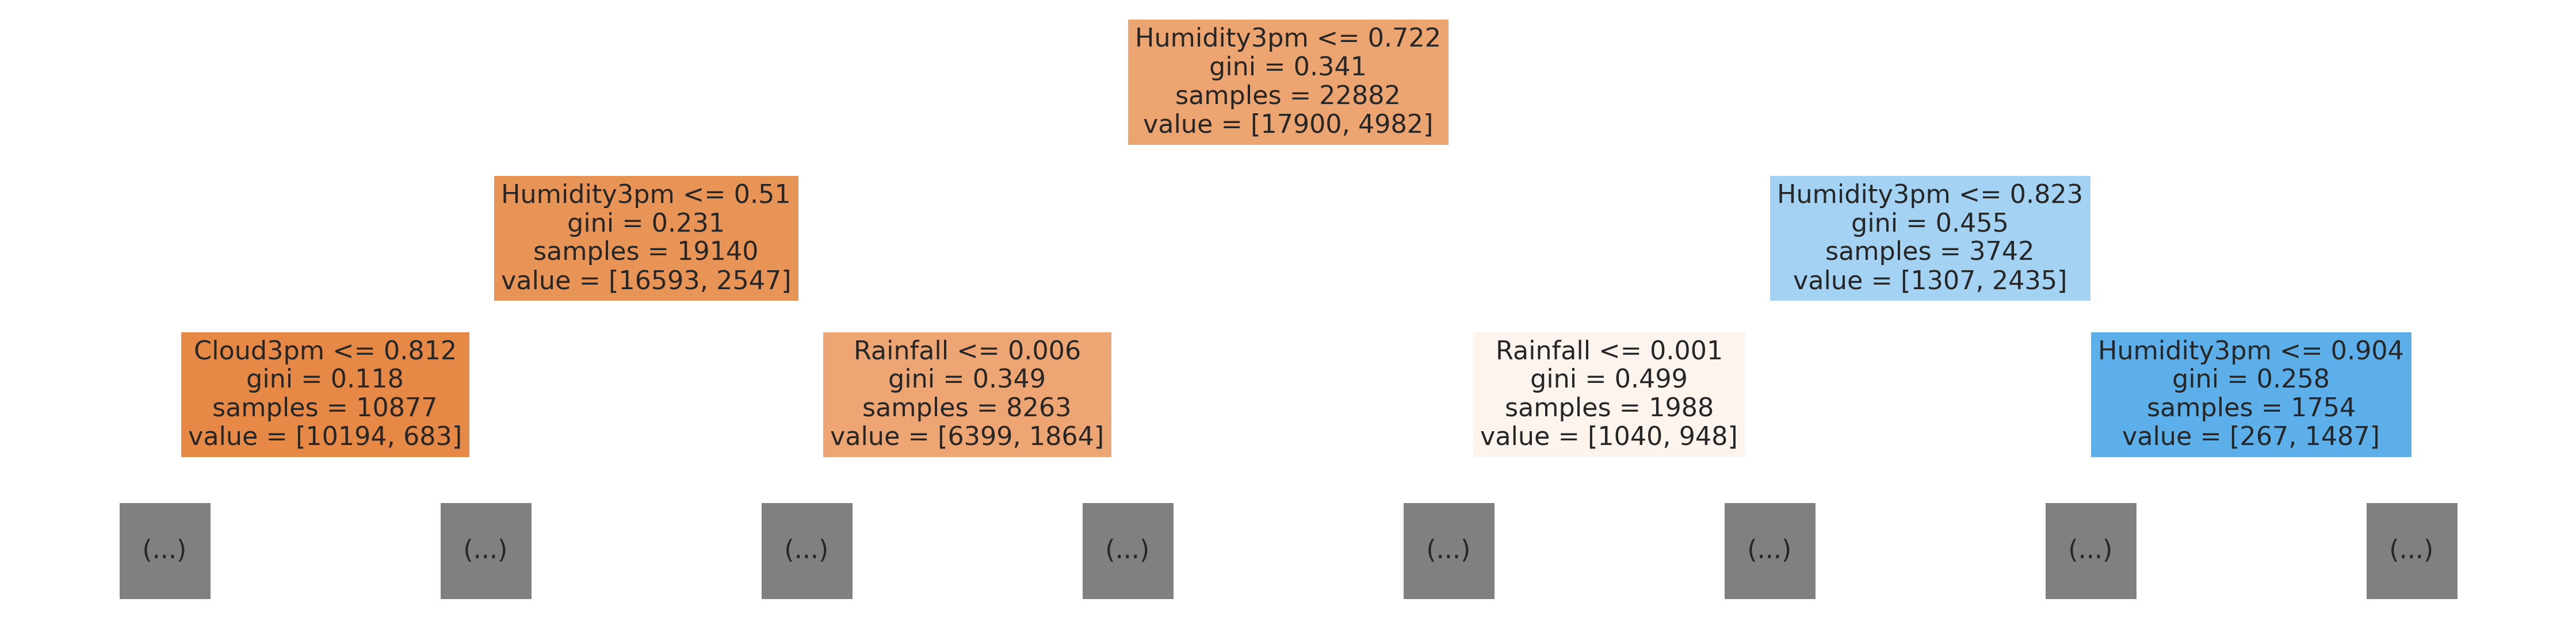

In [76]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

Can you see how the model classifies a given input as a series of decisions? The tree is truncated here, but following any path from the root node down to a leaf will result in "Yes" or "No". Do you see how a decision tree differs from a logistic regression model?


**How a Decision Tree is Created**

Note the `gini` value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0. 

For a mathematical discussion of the Gini Index, watch this video: https://www.youtube.com/watch?v=-W0DnxQK1Eo . It has the following formula:

<img src="https://i.imgur.com/CSC0gAo.png" width="240">

Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

The iterative approach of the machine learning workflow in the case of a decision tree involves growing the tree layer-by-layer:

<img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">


Let's check the depth of the tree that was created.

In [77]:
model.tree_.max_depth

35

We can also display the tree as text, which can be easier to follow for deeper trees.

In [78]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Cloud3pm <= 0.81
|   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |--- Humidity3pm <= 0.44
|   |   |   |   |   |--- WindGustSpeed <= 0.24
|   |   |   |   |   |   |--- Rainfall <= 0.09
|   |   |   |   |   |   |   |--- Pressure3pm <= 0.39
|   |   |   |   |   |   |   |   |--- Pressure9am <= 0.43
|   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |--- Pressure9am >  0.43
|   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- Pressure3pm >  0.39
|   |   |   |   |   |   |   |   |--- Pressure9am <= 0.40
|   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |--- Pressure9am >  0.40
|   |   |   |   |   |   |   |   |   |--- Sunshine <= 0.32
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_ESE <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- WindDi

### Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [79]:
model.feature_importances_

array([0.04533789, 0.04797545, 0.04149454, 0.02258727, 0.03583456,
       0.04520194, 0.02807614, 0.03649607, 0.04722464, 0.32636589,
       0.03501867, 0.03887593, 0.01640223, 0.02667695, 0.04464757,
       0.00314847, 0.00223057, 0.00156694, 0.00216053, 0.0010854 ,
       0.0014205 , 0.0037199 , 0.00209075, 0.0020685 , 0.00141756,
       0.00166096, 0.00281153, 0.00228152, 0.00258121, 0.00276032,
       0.00367914, 0.00293719, 0.00297364, 0.00232727, 0.00286767,
       0.00367773, 0.00282099, 0.00436943, 0.00216277, 0.00121455,
       0.00188447, 0.00261731, 0.00117665, 0.00192768, 0.00170702,
       0.00234511, 0.00269875, 0.00239794, 0.00135355, 0.00159381,
       0.0027233 , 0.00313904, 0.0036986 , 0.00164526, 0.00311911,
       0.00308287, 0.00253535, 0.00318845, 0.0016165 , 0.00373917,
       0.00302858, 0.00214585, 0.00293366, 0.0036774 , 0.0031826 ,
       0.00372775, 0.00258114, 0.00419548, 0.00304393, 0.00579596,
       0.00308017, 0.00246142, 0.00324352, 0.00162038, 0.00165

Let's turn this into a dataframe and visualize the most important features.

In [80]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [81]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.326366
1,MaxTemp,0.047975
8,Humidity9am,0.047225
0,MinTemp,0.045338
5,WindGustSpeed,0.045202
14,Temp9am,0.044648
2,Rainfall,0.041495
11,Pressure3pm,0.038876
7,WindSpeed3pm,0.036496
4,Sunshine,0.035835


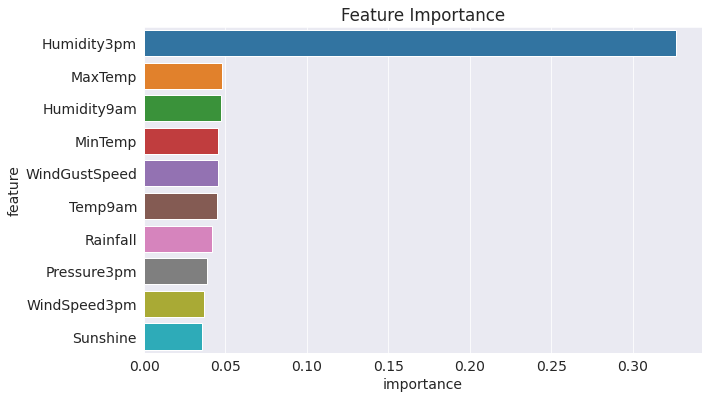

In [82]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. The process of reducing overfitting is known as _regularlization_.


The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.

In [83]:
?DecisionTreeClassifier

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data. We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`

### `max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [84]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)

In [85]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

We can compute the accuracy of the model on the training and validation sets using `model.score`

In [86]:
model.score(X_train, train_targets)

0.8431518223931475

In [87]:
model.score(X_val, val_targets)

0.8130990415335463

Great, while the training accuracy of the model has gone down, the validation accuracy of the model has increased significantly.

In [88]:
model.classes_

array(['No', 'Yes'], dtype=object)

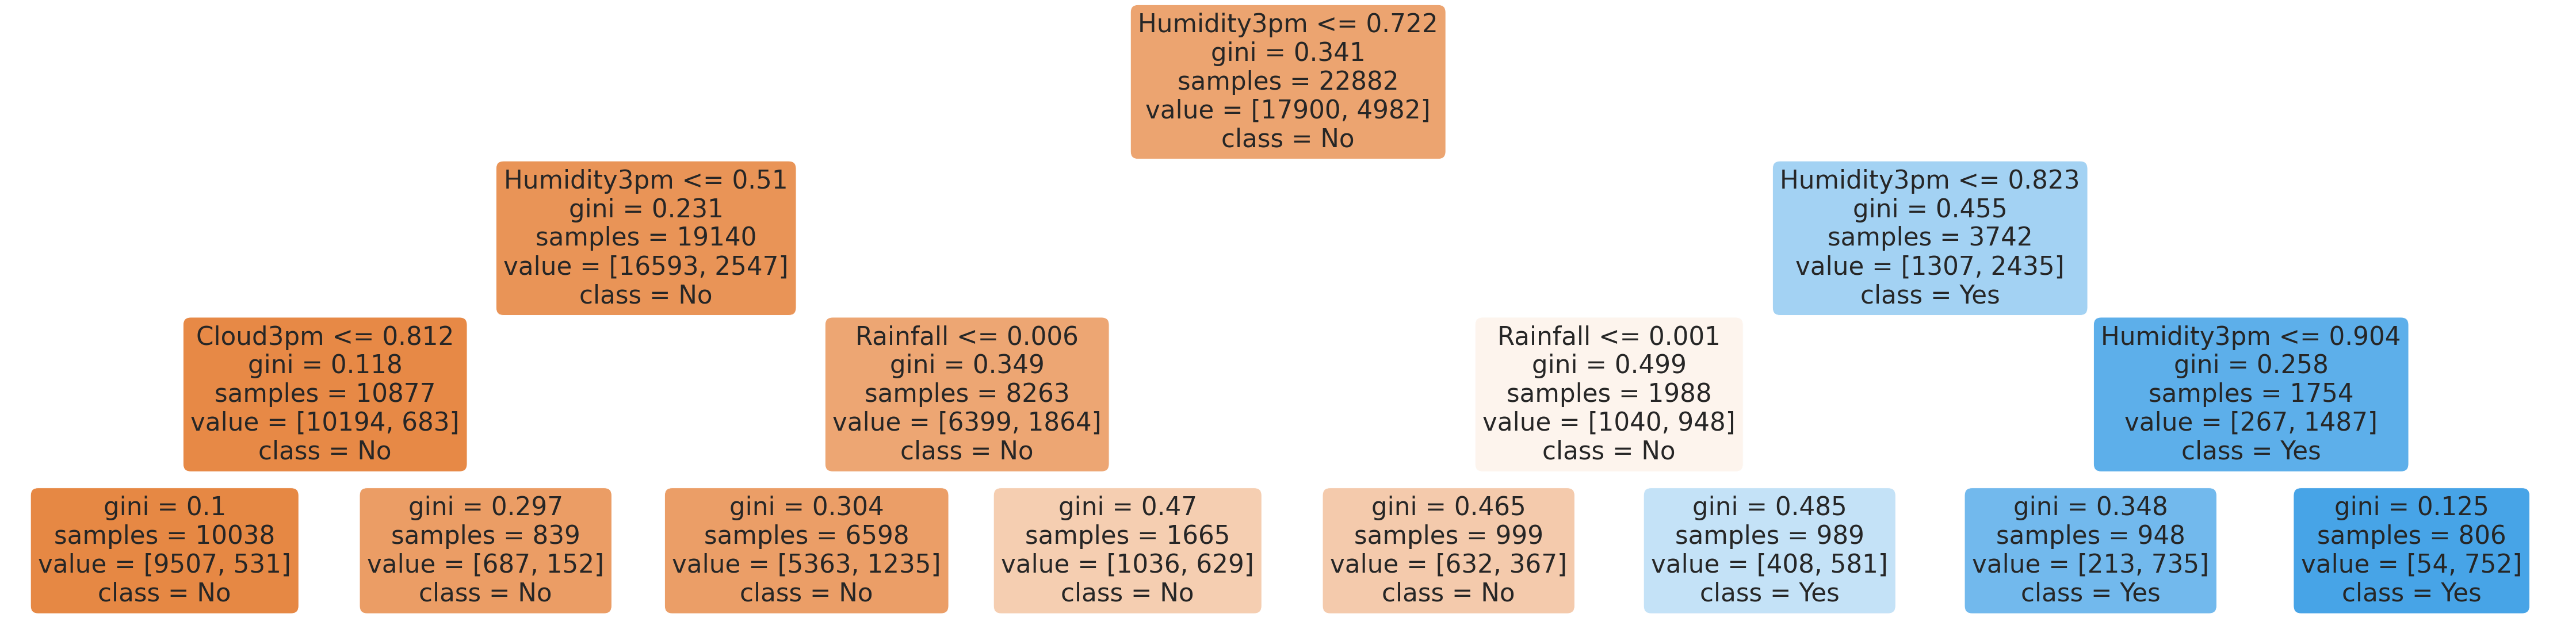

In [89]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

In [90]:
print(export_text(model, feature_names=list(X_train.columns)))

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Cloud3pm <= 0.81
|   |   |   |--- class: No
|   |   |--- Cloud3pm >  0.81
|   |   |   |--- class: No
|   |--- Humidity3pm >  0.51
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: No
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: No
|--- Humidity3pm >  0.72
|   |--- Humidity3pm <= 0.82
|   |   |--- Rainfall <= 0.00
|   |   |   |--- class: No
|   |   |--- Rainfall >  0.00
|   |   |   |--- class: Yes
|   |--- Humidity3pm >  0.82
|   |   |--- Humidity3pm <= 0.90
|   |   |   |--- class: Yes
|   |   |--- Humidity3pm >  0.90
|   |   |   |--- class: Yes



Let's experiment with different depths using a helper function.

In [91]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_acc = 1 - model.score(X_train, train_targets)
    val_acc = 1 - model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [92]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

CPU times: user 7.01 s, sys: 15.3 ms, total: 7.03 s
Wall time: 7 s


In [93]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.168429,0.191427
1,2,0.164409,0.189830
2,3,0.156848,0.186901
3,4,0.152565,0.187700
4,5,0.149462,0.188498
5,6,0.143432,0.186635
6,7,0.137138,0.185037
7,8,0.129010,0.192226
8,9,0.118346,0.191693
9,10,0.106416,0.199148


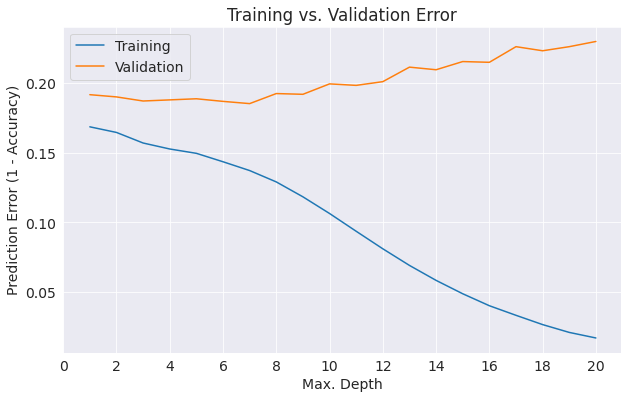

In [94]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

This is a common pattern you'll see with all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">





You'll often need to tune hyperparameters carefully to find the optimal fit. In the above case, it appears that a maximum depth of 7 results in the lowest validation error.

In [95]:
model = DecisionTreeClassifier(max_depth=7, random_state=42).fit(X_train, train_targets)
model.score(X_val, val_targets)

0.8149627263045793

### `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

In [96]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [97]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=128,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [98]:
model.score(X_train, train_targets)

0.8694607114762696

In [99]:
model.score(X_val, val_targets)

0.8128328008519702

In [100]:
model.tree_.max_depth

13

Notice that the model was able to achieve a greater depth of 12 for certain paths while keeping other paths shorter.

In [101]:
model_text = export_text(model, feature_names=list(X_train.columns))
print(model_text[:3000])

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Cloud3pm <= 0.81
|   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |--- Humidity3pm <= 0.44
|   |   |   |   |   |--- class: No
|   |   |   |   |--- Humidity3pm >  0.44
|   |   |   |   |   |--- MinTemp <= 0.64
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- MinTemp >  0.64
|   |   |   |   |   |   |--- Pressure3pm <= 0.56
|   |   |   |   |   |   |   |--- Pressure9am <= 0.48
|   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |--- Pressure9am >  0.48
|   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |--- Pressure3pm >  0.56
|   |   |   |   |   |   |   |--- class: No
|   |   |   |--- WindGustSpeed >  0.36
|   |   |   |   |--- WindSpeed3pm <= 0.17
|   |   |   |   |   |--- Humidity9am <= 0.56
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity9am >  0.56
|   |   |   |   |   |   |--- WindGustSpeed <= 0.49
|   |   |   |   |   |   |   |--- Pres

## Training a Random Forest

While tuning the hyperparameters of a single decision tree may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest model. 

The key idea here is that each decision tree in the forest will make different kinds of errors, and upon averaging, many of their errors will cancel out. This idea is also commonly known as the "wisdom of the crowd":

<img src="https://i.imgur.com/4Dg0XK4.png" width="480">

A random forest works by averaging/combining the results of several decision trees:

<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif" width="640">


We'll use the `RandomForestClassifier` class from `sklearn.ensemble`.

In [102]:
from sklearn.ensemble import RandomForestClassifier

In [103]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)

`n_jobs` allows the random forest to use mutiple parallel workers to train decision trees, and `random_state=42` ensures that the we get the same results for each execution.

In [104]:
%%time
model.fit(X_train, train_targets)

CPU times: user 5.93 s, sys: 37.8 ms, total: 5.96 s
Wall time: 3.18 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [105]:
model.score(X_train, train_targets)

0.99991259505288

In [106]:
model.score(X_val, val_targets)

0.8293397231096912

Once again, the training accuracy is almost 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree we had trained so far. Do you see the power of random forests?

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="640">


We can also look at the probabilities for the predictions. The probability of a class is simply the fraction of trees which that predicted the given class.

In [107]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.97, 0.03],
       [0.99, 0.01],
       [1.  , 0.  ],
       ...,
       [0.95, 0.05],
       [0.96, 0.04],
       [0.94, 0.06]])

We can can access individual decision trees using `model.estimators_`

In [108]:
model.estimators_[0]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1608637542, splitter='best')

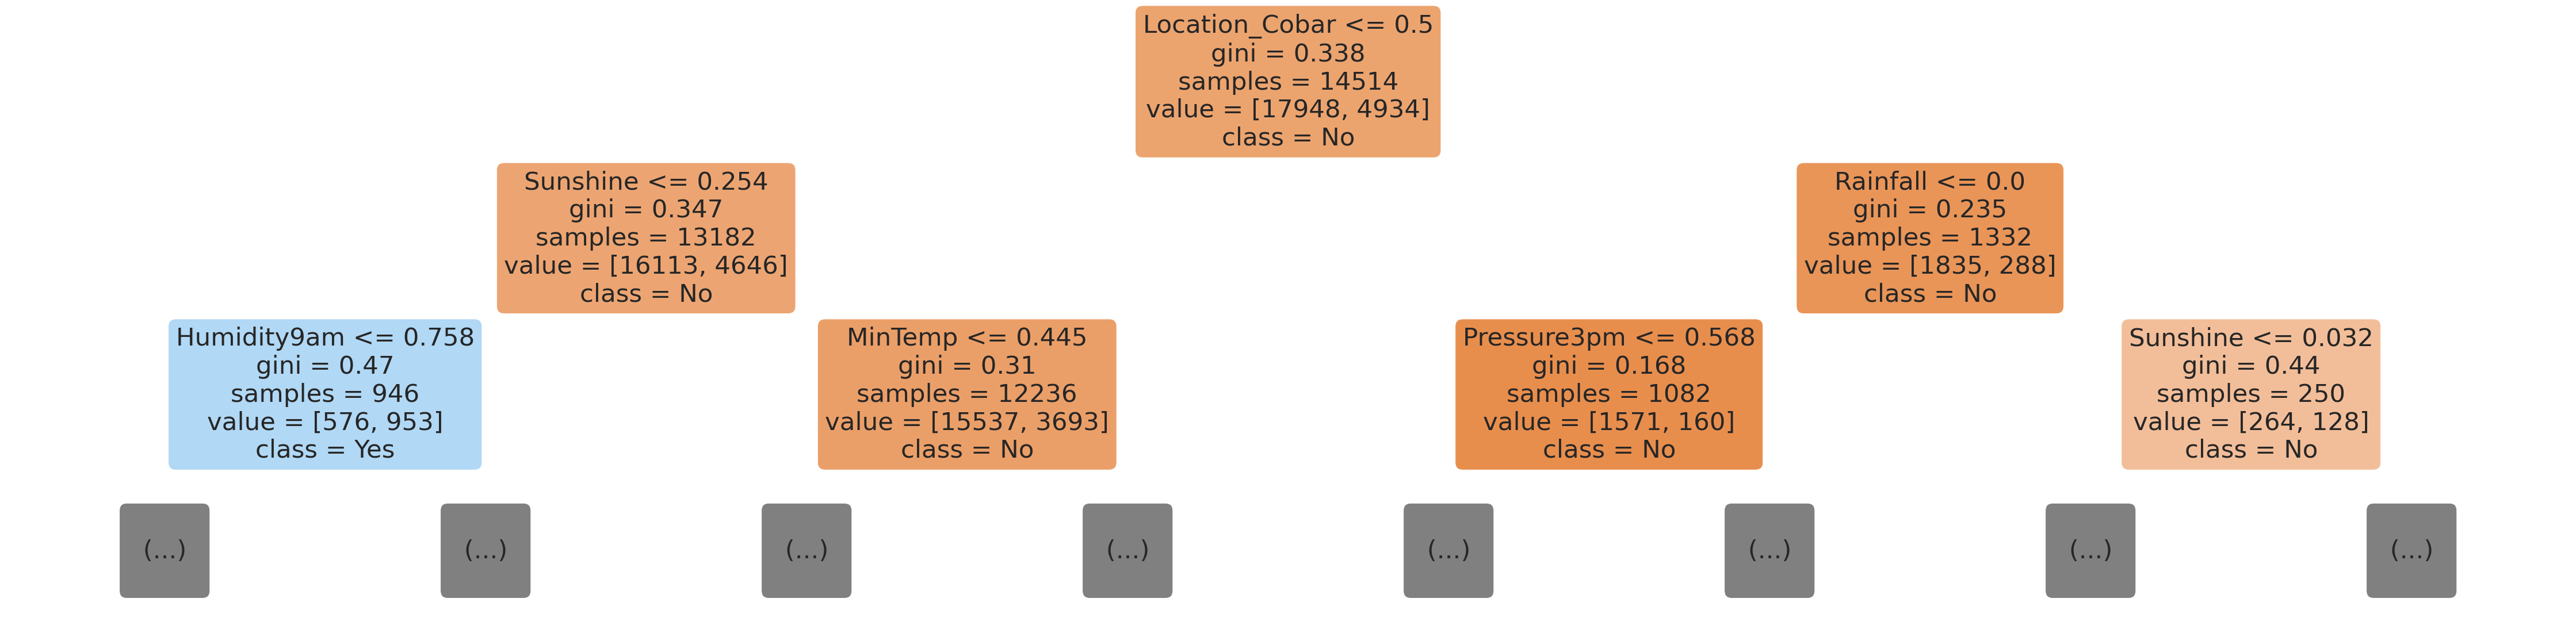

In [109]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

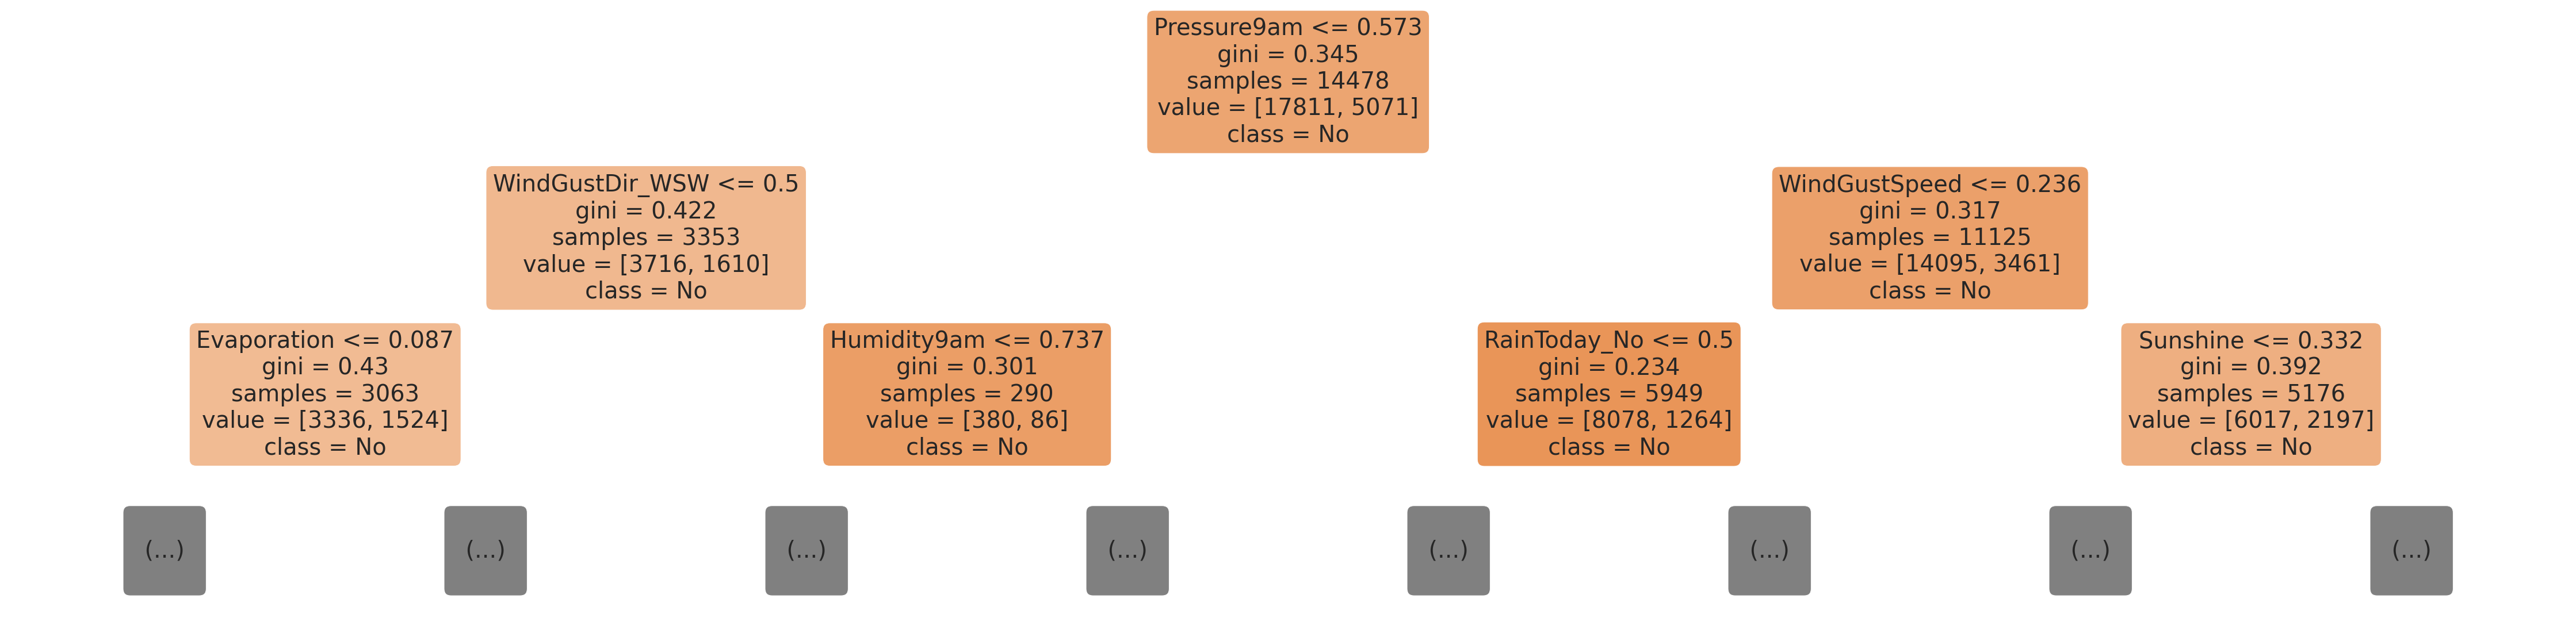

In [110]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[20], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

In [111]:
len(model.estimators_)

100

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [112]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [113]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.173056
8,Humidity9am,0.062402
1,MaxTemp,0.053082
0,MinTemp,0.051469
4,Sunshine,0.046645
14,Temp9am,0.046297
5,WindGustSpeed,0.044985
13,Cloud3pm,0.044473
2,Rainfall,0.043809
11,Pressure3pm,0.039490


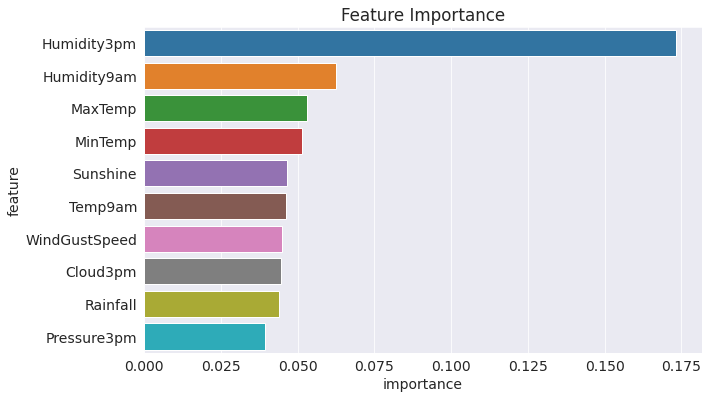

In [114]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Notice that the distribution is a lot less skewed than that for a single decision tree.

## Hyperparameter Tuning with Random Forests

Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees. 

Let's study some the hyperparameters for random forests. You can learn more about them here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [115]:
?RandomForestClassifier

Let's create a base model with which we can compare models with tuned hyperparameters.

In [116]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, train_targets)

In [117]:
base_train_acc = base_model.score(X_train, train_targets)
base_val_acc = base_model.score(X_val, val_targets)

In [118]:
base_accs = base_train_acc, base_val_acc
base_accs

(0.99991259505288, 0.8293397231096912)

We can use this as a benchmark for hyperparmeter tuning.

### `n_estimators`

This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed. 


**10 estimators**

In [119]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10)

In [120]:
model.fit(X_train, train_targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [121]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9856655886723189, 0.8189563365282215)

In [122]:
base_accs

(0.99991259505288, 0.8293397231096912)

**500 estimators**

In [123]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500)
model.fit(X_train, train_targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [124]:
model.score(X_train, train_targets)

0.99991259505288

In [125]:
model.score(X_val, val_targets)

0.8317358892438764

In [126]:
base_accs

(0.99991259505288, 0.8293397231096912)

### `max_depth` and `max_leaf_nodes`

These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. By default, no maximum depth is specified, which is why each tree has a training accuracy of 100%. You can specify a `max_depth` to reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">


Let's define a helper function `test_params` to make it easy to test hyperparameters.

In [127]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    return model.score(X_train, train_targets), model.score(X_val, val_targets)

Let's test a few values of `max_depth` and `max_leaf_nodes`.

In [128]:
test_params(max_depth=5)

(0.8392185997727472, 0.8075079872204473)

In [129]:
test_params(max_depth=26)

(0.9952801328555196, 0.8296059637912673)

In [130]:
test_params(max_leaf_nodes=2**5)

(0.8445503015470676, 0.8123003194888179)

In [131]:
test_params(max_leaf_nodes=2**20)

(0.99991259505288, 0.8312034078807242)

In [132]:
base_accs # no max depth or max leaf nodes

(0.99991259505288, 0.8293397231096912)

The optimal values of `max_depth` and `max_leaf_nodes` lies somewhere between 0 and unbounded.

### `max_features`

Instead of picking all features (columns) for every split, we can specify that only a fraction of features be chosen randomly to figure out a split.

<img src="https://i.imgur.com/FXGWMDY.png" width="720">

Notice that the default value `auto` causes only $\sqrt{n}$ out of total features ( $n$ ) to be chosen randomly at each split. This is the reason each decision tree in the forest is different. While it may seem counterintuitive, choosing all features for every split of every tree will lead to identical trees, so the random forest will not generalize well. 

In [133]:
test_params(max_features='log2')

(0.99991259505288, 0.8304046858359957)

In [134]:
test_params(max_features=3)

(0.99991259505288, 0.8285410010649628)

In [135]:
test_params(max_features=6)

(0.99991259505288, 0.8304046858359957)

In [136]:
base_accs

(0.99991259505288, 0.8293397231096912)

### `min_samples_split` and `min_samples_leaf`

By default, the decision tree classifier tries to split every node that has 2 or more. You can increase the values of these arguments to change this behavior and reduce overfitting, especially for very large datasets.

In [137]:
test_params(min_samples_split=3, min_samples_leaf=2)

(0.9595752119569968, 0.8298722044728435)

In [138]:
test_params(min_samples_split=100, min_samples_leaf=60)

(0.8530285814177082, 0.8189563365282215)

In [139]:
base_accs

(0.99991259505288, 0.8293397231096912)

### `min_impurity_decrease`

This argument is used to control the threshold for splitting nodes. A node will be split if this split induces a decrease of the impurity (Gini index) greater than or equal to this value. It's default value is 0, and you can increase it to reduce overfitting.



In [140]:
test_params(min_impurity_decrease=1e-7)

(0.99991259505288, 0.8282747603833865)

In [141]:
test_params(min_impurity_decrease=1e-2)

(0.7822742767240626, 0.7582534611288605)

In [142]:
base_accs

(0.99991259505288, 0.8293397231096912)

### `bootstrap`, `max_samples` 

By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called bootstrapping. For each tree, rows from the dataset are picked one by one randomly, with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.


<img src="https://i.imgur.com/W8UGaEA.png" width="640">

Bootstrapping helps the random forest generalize better, because each decision tree only sees a fraction of th training set, and some rows randomly get higher weightage than others.

In [143]:
test_params(bootstrap=False)

(0.99991259505288, 0.8341320553780618)

In [144]:
base_accs

(0.99991259505288, 0.8293397231096912)

When bootstrapping is enabled, you can also control the number or fraction of rows to be considered for each bootstrap using `max_samples`. This can further generalize the model.

<img src="https://i.imgur.com/rsdrL1W.png" width="640">

In [145]:
test_params(max_samples=0.9)

(0.99965038021152, 0.8317358892438764)

In [146]:
base_accs

(0.99991259505288, 0.8293397231096912)

### `class_weight`

In [147]:
model.classes_

array(['No', 'Yes'], dtype=object)

In [148]:
test_params(class_weight='balanced')

(0.99991259505288, 0.8322683706070287)

In [149]:
test_params(class_weight={'No': 1, 'Yes': 2})

(0.99991259505288, 0.8343982960596379)

In [150]:
base_accs

(0.99991259505288, 0.8293397231096912)

### Putting it together

Let's train a random forest with customized hyperparameters based on our learnings. Of course, different hyperpraams

In [151]:
model = RandomForestClassifier(n_jobs=-1, 
                               random_state=42, 
                               n_estimators=500,
                               max_features=7,
                               max_depth=30, 
                               class_weight={'No': 1, 'Yes': 1.5})

In [152]:
model.fit(X_train, train_targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={'No': 1, 'Yes': 1.5}, criterion='gini',
                       max_depth=30, max_features=7, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [153]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.99969408268508, 0.8320021299254526)

In [154]:
base_accs

(0.99991259505288, 0.8293397231096912)

We've increased the accuracy from 84.5% with a single decision tree to 85.7% with a well-tuned random forest. Depending on the dataset and the kind of problem, you may or may not a see a significant improvement with hyperparameter tuning. 

This could be due to any of the following reasons:

- We may not have found the right mix of hyperparameters to regularize (reduce overfitting) the model properly, and we should keep trying to improve the model.

- We may have reached the limits of the modeling technique we're currently using (Random Forests), and we should try another modeling technique e.g. gradient boosting.

- We may have reached the limits of what we can predict using the given amount of data, and we may need more data to improve the model.

- We may have reached the limits of how well we can predict whether it will rain tomorrow using the given weather measurements, and we may need more features (columns) to further improve the model. In many cases, we can also generate new features using existing features (this is called feature engineering).

- Whether it will rain tomorrow may be an inherently random or chaotic phenomenon which simply cannot be predicted beyond a certain accuracy any amount of data for any number of weather measurements with any modeling technique.  

Remember that ultimately all models are wrong, but some are useful. If you can rely on the model we've created today to make a travel decision for tomorrow, then the model is useful, even though it may sometimes be wrong.

In [155]:
raw_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32891,2015-10-06,Sydney,20.3,32.3,0.0,8.6,11.4,NNE,43.0,WNW,ENE,15.0,17.0,37.0,26.0,1023.2,1019.7,1.0,1.0,23.8,30.6,No,No
32892,2015-10-07,Sydney,19.7,21.5,0.0,13.2,1.3,SSW,67.0,SSE,SE,39.0,26.0,61.0,56.0,1029.6,1033.6,5.0,7.0,20.3,19.0,No,No
32893,2015-10-08,Sydney,17.0,21.1,0.0,6.6,2.2,ENE,35.0,ESE,E,13.0,20.0,53.0,57.0,1038.8,1036.0,7.0,7.0,18.5,19.9,No,No
32894,2015-10-09,Sydney,16.8,22.7,0.0,5.4,8.7,ENE,43.0,N,NE,15.0,24.0,51.0,51.0,1034.4,1029.7,7.0,5.0,20.1,22.0,No,No


Finally, let's also compute the accuracy of our model on the test set.

In [156]:
model.score(X_test, test_targets)

0.8438576349024111

Notice that the test accuracy is lower

## Making Predictions on New Inputs

Let's define a helper function to make predictions on new inputs.

In [157]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

In [158]:
new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [159]:
predict_input(model, new_input)

('No', 0.5387859173709653)

## Summary and References

The following topics were covered in this tutorial:

- Downloading a real-world dataset
- Preparing a dataset for training
- Training and interpreting decision trees
- Training and interpreting random forests
- Overfitting, hyperparameter tuning & regularization
- Making predictions on single inputs



We also introduced the following terms:

* Decision tree
* Random forest
* Overfitting
* Hyperparameter
* Hyperparameter tuning
* Regularization
* Ensembling
* Generalization
* Bootstrapping
